 Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

# This was run a Jupyter Notebook Environment

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

# Note : Run Below Commented Cell to delete the images created by Augmentor in the output dir of each of the classes , in case the code has to be executed from the start

In [2]:
# import shutil
# data_dir_train_out = pathlib.Path(r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
# if data_dir_train_out.glob('*/output') : 
    
#     for i in data_dir_train_out.glob('*/output') :
#         shutil.rmtree(i)
    

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path(r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
# data_dir_test = pathlib.Path(r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# In case this is being run in a google colab env please change the \ \ in split to /

In [5]:
def image_stats(_dir) :
    l = [(str(i),str(i).split('\\')[-2]) for i in _dir.glob(r'*/*.jpg')]
    dir_paths = np.array(l)[:,0]
    val_counts = np.array(l)[:,1]
    df = pd.Series(val_counts).value_counts()
    df = df.reset_index()
    df.columns = ['class','count']
    df['percent'] = 100 * df['count'] / df['count'].sum()
    display(df)
    return dir_paths,df

In [6]:
dir_paths,tr_df = image_stats(data_dir_train)


class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

In [7]:
test_path,ts_df = image_stats(data_dir_test)

class  count    percent
0           actinic keratosis     16  13.559322
1        basal cell carcinoma     16  13.559322
2              dermatofibroma     16  13.559322
3                    melanoma     16  13.559322
4                       nevus     16  13.559322
5  pigmented benign keratosis     16  13.559322
6     squamous cell carcinoma     16  13.559322
7        seborrheic keratosis      3   2.542373
8             vascular lesion      3   2.542373

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
# Creating the Test and Validation sets , 80% of data goes to training while the validation set has 20% of the data
# Each of the images are of size (180,180,3) -> 180 and 180 are height and width while 3 is the noof channels
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# In case this is being run in a google colab env please change the \ \ in split to /

In [11]:
# Preparing Sample images of each class
sample_class = {}
for j in dir_paths :
    class_holder = j.split('\\')[-2]
    if sample_class :
        if class_holder in sample_class.keys() :
            continue
        sample_class[class_holder] = j
    sample_class[class_holder] = j

    if len(sample_class) == len(class_names) :
        break





# Plot single instance of each class 

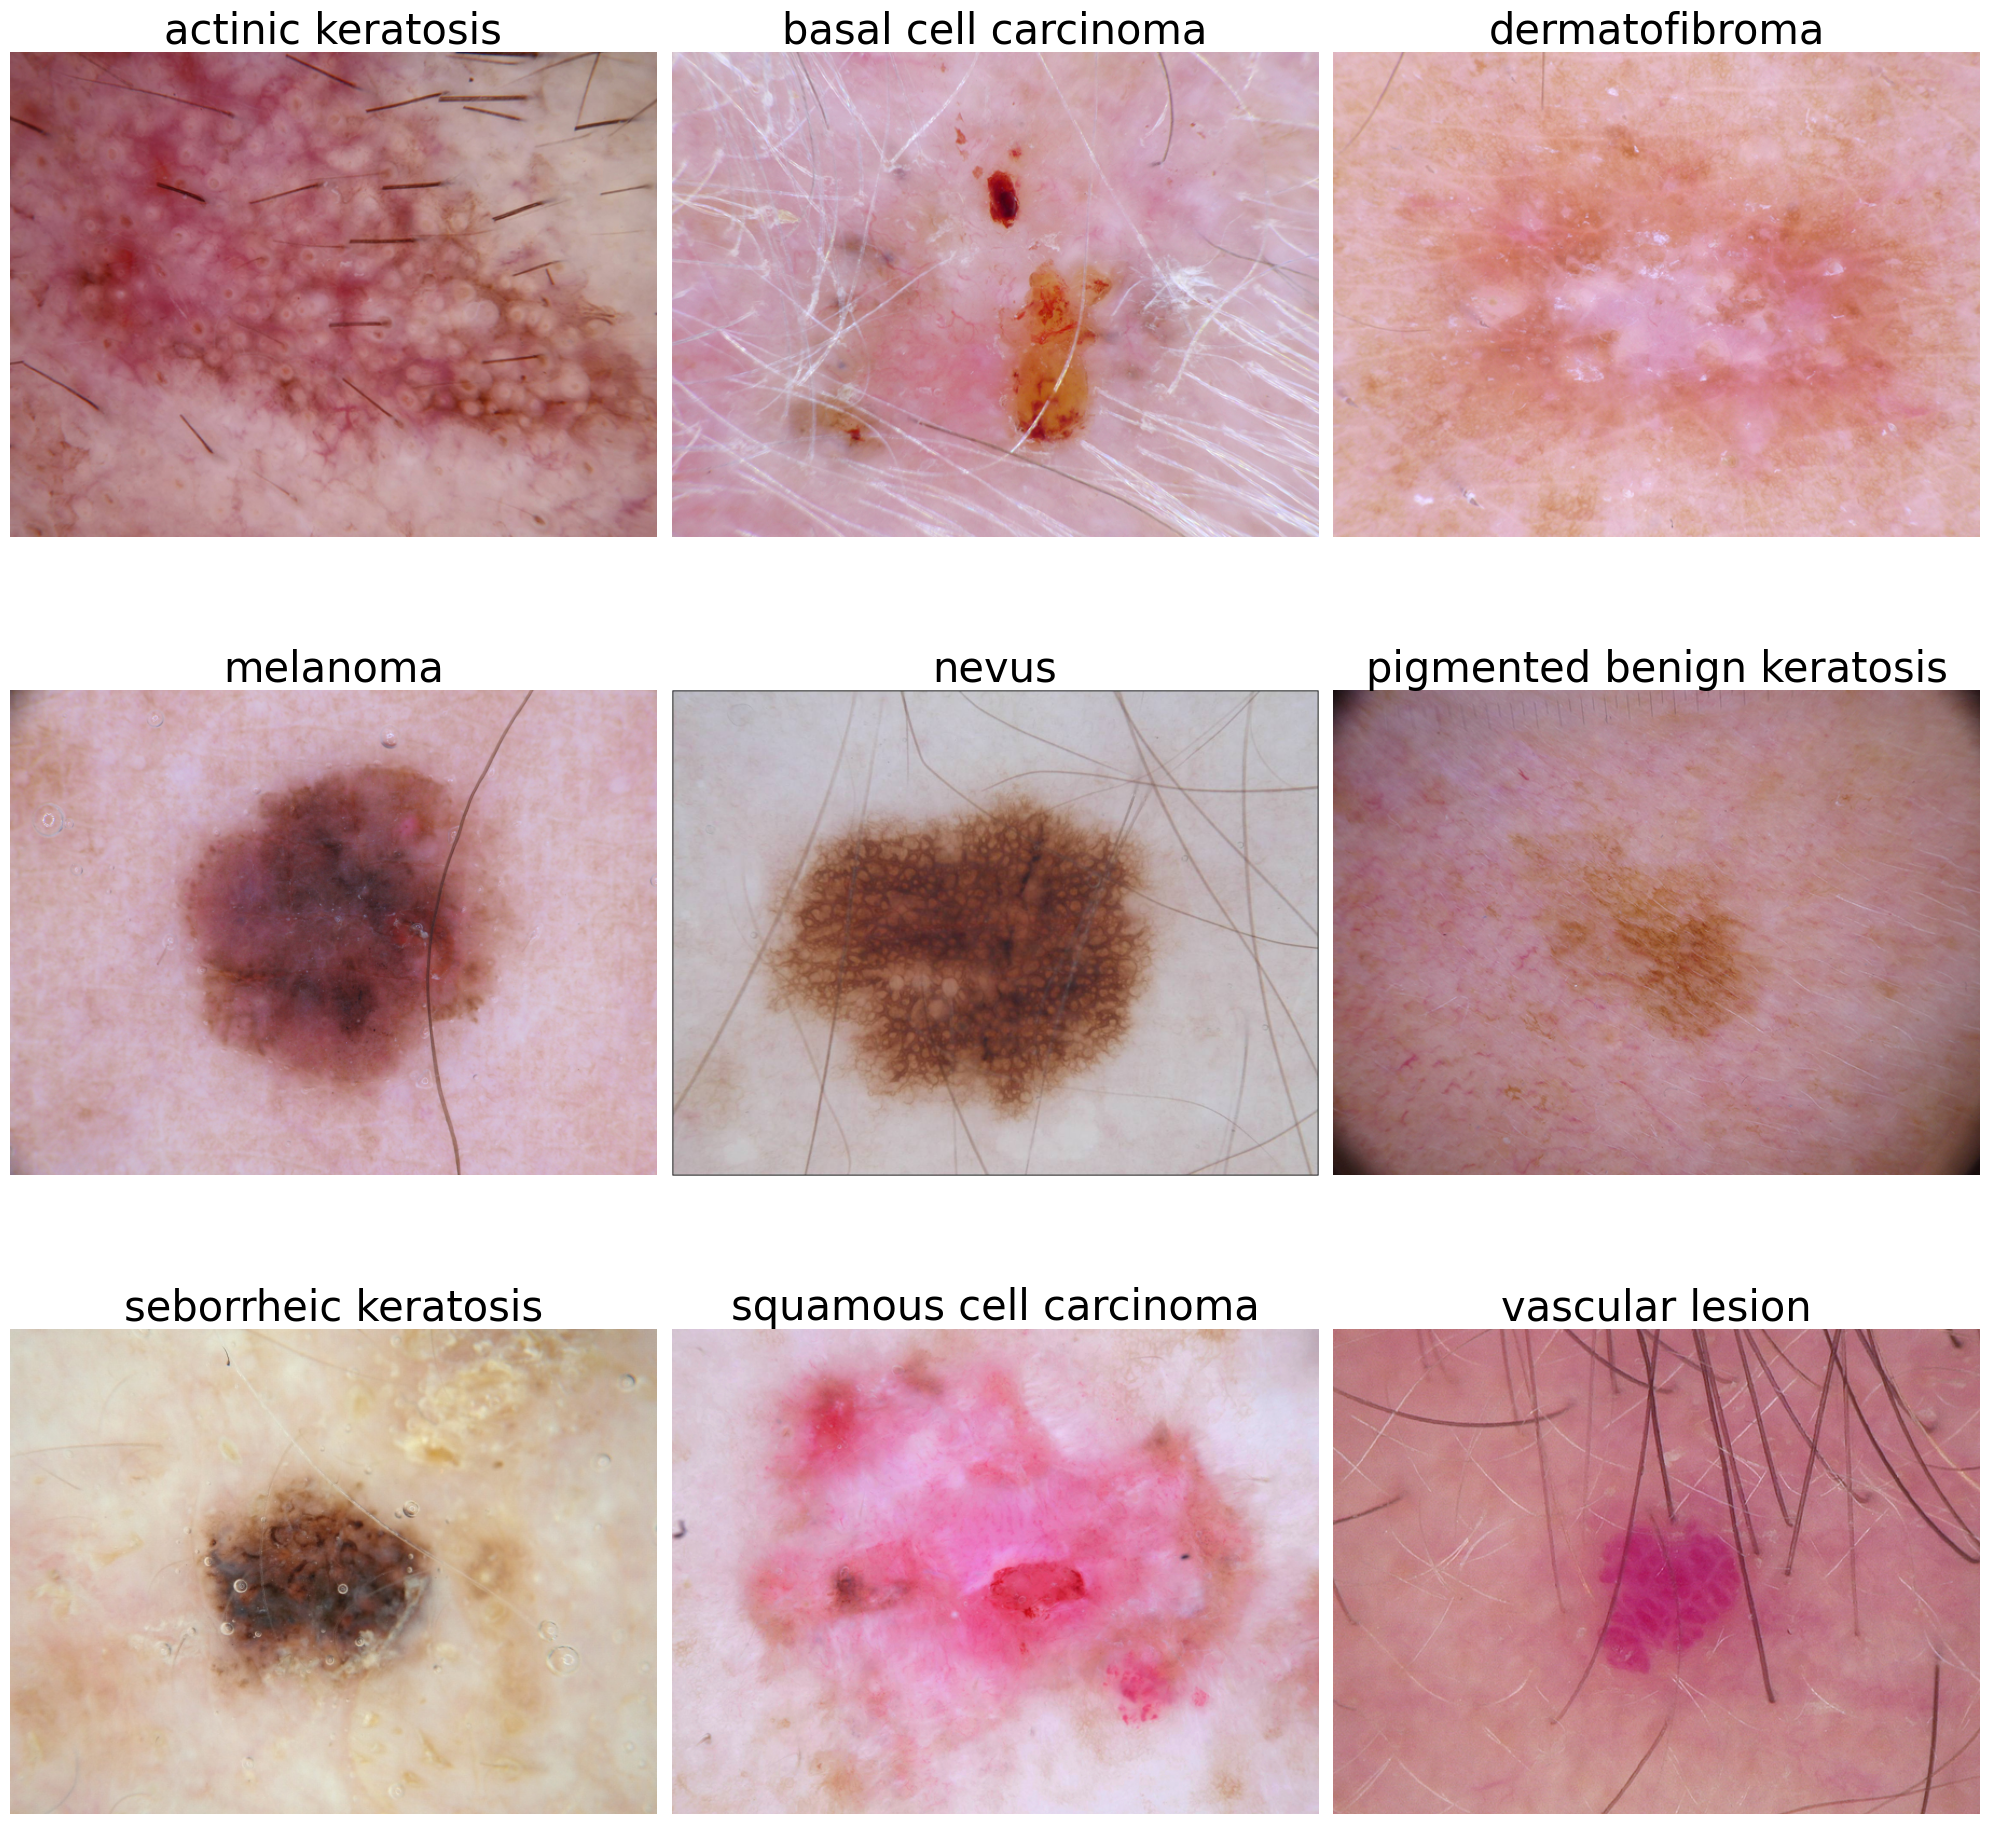

In [14]:
fig,ax = plt.subplots(3,3,figsize=(20,20))
for idx,(cat,val) in enumerate(sample_class.items()) :
    idx2 = idx % 3
    idx1 = idx // 3
    ax[idx1,idx2].imshow(PIL.Image.open(val))
    ax[idx1,idx2].axis('off')
    ax[idx1,idx2].set_title(cat,fontsize=30)
plt.tight_layout()
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [15]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    # layers.Dropout(0.1),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 15s 133ms/step - loss: 2.0809 - accuracy: 0.2673 - val_loss: 1.8250 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 7s 123ms/step - loss: 1.7098 - accuracy: 0.4012 - val_loss: 1.6333 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 7s 123ms/step - loss: 1.5865 - accuracy: 0.4448 - val_loss: 1.4881 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 8s 132ms/step - loss: 1.4610 - accuracy: 0.4972 - val_loss: 1.4449 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 7s 123ms/step - loss: 1.4214 - accuracy: 0.5078 - val_loss: 1.4505 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 7s 127ms/step - loss: 1.3088 - accuracy: 0.5340 - val_loss: 1.4488 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 8s 139ms/step - loss: 1.1686 - accuracy: 0.5921 - val_loss: 1.4538 - val_accuracy: 0.4966
Epoch

### Visualizing training results

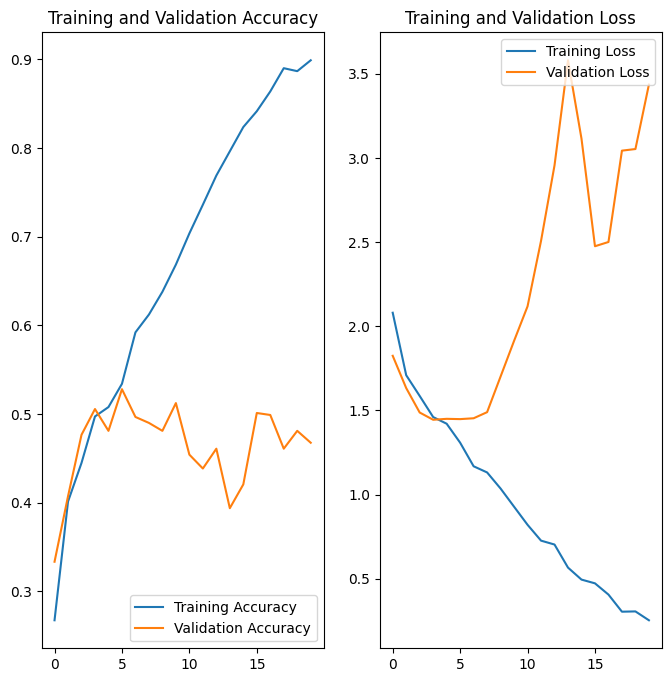

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Train the Same model this time with Dropouts and Batch Normalization

In [23]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 176, 176, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                      

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 180ms/step - loss: 7.3085 - accuracy: 0.2561 - val_loss: 2.1904 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 10s 174ms/step - loss: 2.0804 - accuracy: 0.2863 - val_loss: 2.4067 - val_accuracy: 0.0671
Epoch 3/20
56/56 [==============================] - 10s 178ms/step - loss: 1.9594 - accuracy: 0.3276 - val_loss: 3.4069 - val_accuracy: 0.1387
Epoch 4/20
56/56 [==============================] - 11s 188ms/step - loss: 1.9034 - accuracy: 0.3097 - val_loss: 4.9336 - val_accuracy: 0.1902
Epoch 5/20
56/56 [==============================] - 11s 192ms/step - loss: 1.7196 - accuracy: 0.3973 - val_loss: 14.1237 - val_accuracy: 0.1409
Epoch 6/20
56/56 [==============================] - 11s 185ms/step - loss: 1.6795 - accuracy: 0.4079 - val_loss: 2.1430 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 10s 176ms/step - loss: 1.6481 - accuracy: 0.4302 - val_loss: 1.9376 - val_accuracy: 0.297

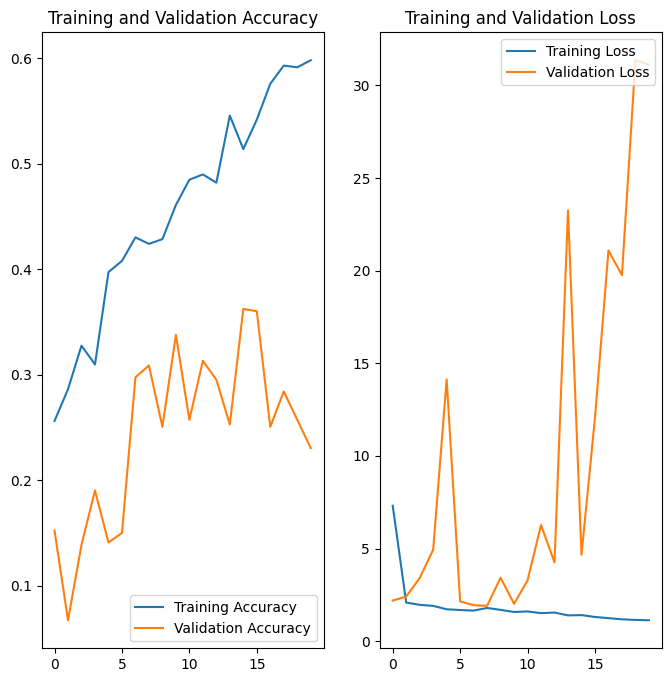

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations
 - It can be clearly seen that the model has overfit . While the training accuracy shows clear signs of increasing , the testing accuracy moves very slowly.
 - The same can be observed with loss too . While the Training Loss keeps moving down , the testing loss keeps increasing
 -  Also applying Dropouts and Batch Normalization has affected both the test training accuracies in a negative way
 -  Though the gap btw train and test scores has gone down

# Augumentation using Image Data Generator

In [12]:
datagen = ImageDataGenerator(
        # rescale=1./255,
        rotation_range = 25,
        width_shift_range = .05,
        height_shift_range = .03,
        fill_mode = 'nearest',
        # vertical_flip=True,
        shear_range = 0.25,
        zoom_range = 0.2,
        horizontal_flip=True,
        validation_split = .2)

train_ds= datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
         subset='training',
        seed = 123,
        class_mode = 'categorical'
        )
val_ds = datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='validation',
        seed = 123,
        class_mode = 'categorical'
)


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


In [28]:
train_ds.class_indices


{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6,
 'squamous cell carcinoma': 7,
 'vascular lesion': 8}

## Without Batch Normalization or Dropouts

In [29]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 84, 84, 64)        36928     
                                                        

In [30]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 23s 401ms/step - loss: 2.2195 - accuracy: 0.2195 - val_loss: 1.9770 - val_accuracy: 0.3626
Epoch 2/20
57/57 [==============================] - 22s 388ms/step - loss: 1.7140 - accuracy: 0.3794 - val_loss: 1.9293 - val_accuracy: 0.3063
Epoch 3/20
57/57 [==============================] - 21s 374ms/step - loss: 1.5797 - accuracy: 0.4384 - val_loss: 1.8336 - val_accuracy: 0.3356
Epoch 4/20
57/57 [==============================] - 21s 375ms/step - loss: 1.6277 - accuracy: 0.4357 - val_loss: 1.6571 - val_accuracy: 0.3941
Epoch 5/20
57/57 [==============================] - 21s 377ms/step - loss: 1.4726 - accuracy: 0.4947 - val_loss: 1.9596 - val_accuracy: 0.3739
Epoch 6/20
57/57 [==============================] - 21s 366ms/step - loss: 1.4305 - accuracy: 0.5103 - val_loss: 2.6166 - val_accuracy: 0.4099
Epoch 7/20
57/57 [==============================] - 21s 369ms/step - loss: 1.3910 - accuracy: 0.5259 - val_loss: 1.8807 - val_accuracy: 0.4414

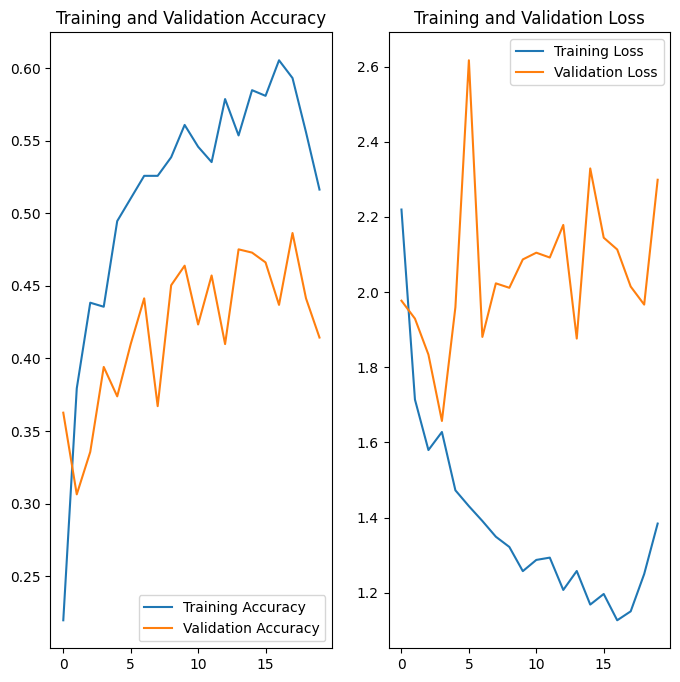

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Batch Normalization or Dropouts

In [13]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 176, 176, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 176, 176, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                      

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 28s 395ms/step - loss: 11.0025 - accuracy: 0.2490 - val_loss: 10.8851 - val_accuracy: 0.1126
Epoch 2/20
57/57 [==============================] - 21s 362ms/step - loss: 2.1228 - accuracy: 0.3181 - val_loss: 34.2709 - val_accuracy: 0.2072
Epoch 3/20
57/57 [==============================] - 21s 370ms/step - loss: 1.9869 - accuracy: 0.3510 - val_loss: 63.8667 - val_accuracy: 0.2072
Epoch 4/20
57/57 [==============================] - 21s 365ms/step - loss: 1.9854 - accuracy: 0.3354 - val_loss: 43.0368 - val_accuracy: 0.2477
Epoch 5/20
57/57 [==============================] - 21s 374ms/step - loss: 1.8688 - accuracy: 0.3939 - val_loss: 66.1518 - val_accuracy: 0.2072
Epoch 6/20
57/57 [==============================] - 22s 392ms/step - loss: 1.8660 - accuracy: 0.3939 - val_loss: 2.7936 - val_accuracy: 0.1757
Epoch 7/20
57/57 [==============================] - 22s 380ms/step - loss: 1.8528 - accuracy: 0.3877 - val_loss: 9.4651 - val_accuracy: 

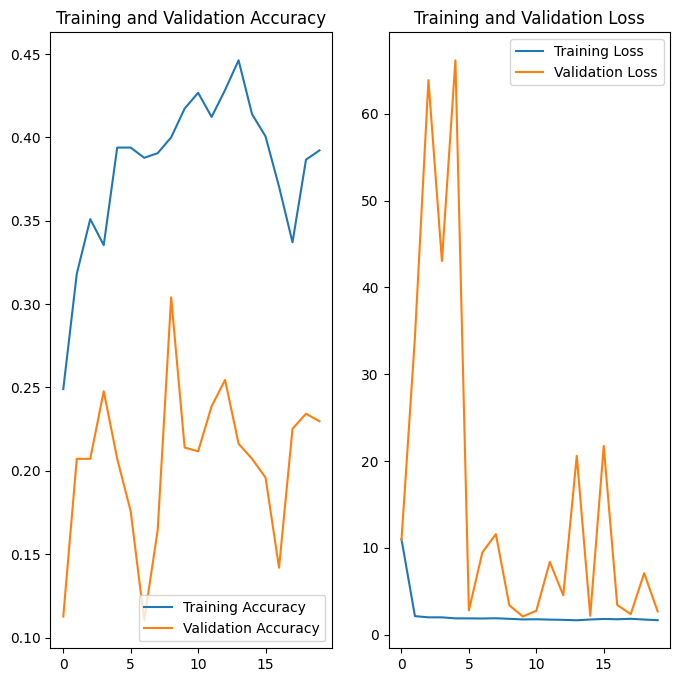

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observations
  - It can be seen that while the rate of overfitting reduced , testing accuracies have come down
  - Batch Normalization and Dropouts didn't seem to work in this case
  - They brought down both train and val scores
  - Let us look the class distribution to get a clearer picture of why this is happening
  - Applying Augmentation based on classes might be a good idea

In [20]:
tr_df

class  count    percent
0  pigmented benign keratosis    462  20.634212
1                    melanoma    438  19.562305
2        basal cell carcinoma    376  16.793211
3                       nevus    357  15.944618
4     squamous cell carcinoma    181   8.083966
5             vascular lesion    139   6.208129
6           actinic keratosis    114   5.091559
7              dermatofibroma     95   4.242966
8        seborrheic keratosis     77   3.439035

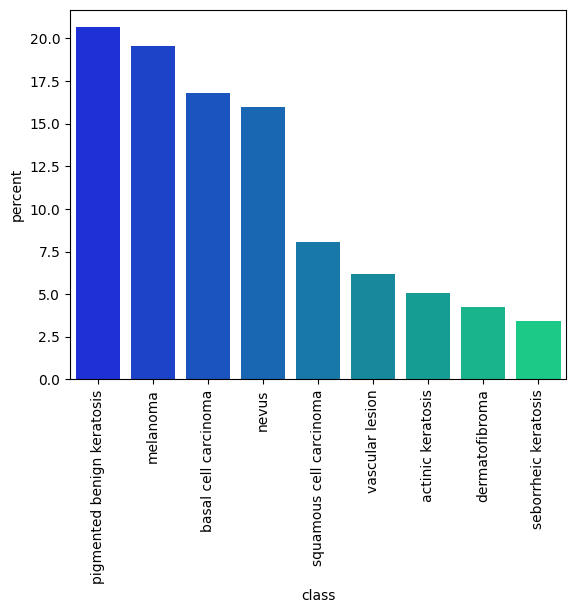

In [21]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()

# Observations
- It can be observed that the classes starting from squamous cell carcinoma have very few values
- Dealing with the imbalance here might increase accuracy
- Pigmened benign keratosis has the highest samples , while seborrheic keratosis has the least samples in the dataset

# Rectify Class Imbalance using the Augmentor Library


In [ ]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.
4. Probabilities Generated from Random Sampling - [0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]--> 2500 images


In [22]:
# Applying Augmentor
import Augmentor
import numpy as np
# p_rotate_norm = np.random.uniform(0.3,.65)
# p_skew = np.random.uniform(0.4,.7)
# p_flip = np.random.uniform(0.4,.6)
# p_rotate = np.random.uniform(0.3,.6)
# p_distortion = np.random.uniform(0.15,.5)
p_rotate_norm,p_skew,p_flip,p_rotate, p_distortion = [0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]
path_to_training_dataset = r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + "\\" + i)
    p.rotate(probability=p_rotate_norm, max_left_rotation=25, max_right_rotation=25)
    p.skew_corner(probability=p_skew)
    p.flip_left_right(probability=p_flip)
    # p.rotate_random_90(probability = p_rotate)
    p.random_distortion(probability = p_distortion,grid_width = 10,grid_height=10,magnitude=np.random.randint(5,9))
    p.sample(2500) ## We are adding 2500 samples per class to make sure that none of the classes are sparse.


Initialised with 114 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290AF71C100>: 100%|█| 2500/2500 [00:09<00:00, 265.16 Sampl


Initialised with 376 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290AFDC34C0>: 100%|█| 2500/2500 [00:09<00:00, 251.71 Sampl


Initialised with 95 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x28FBC107E80>: 100%|█| 2500/2500 [00:10<00:00, 239.83 Sampl


Initialised with 438 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x28FBC0D07C0>: 100%|█| 2500/2500 [00:49<00:00, 50.27 Samp


Initialised with 462 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290AF6835B0>: 100%|█| 2500/2500 [00:11<00:00, 217.39 S


Initialised with 77 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x290AF66B6A0>: 100%|█| 2500/2500 [00:21<00:00, 113.78 


Initialised with 181 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290AF6816F0>: 100%|█| 2500/2500 [00:10<00:00, 234.98 S


Initialised with 139 image(s) found.
Output directory set to C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x290AF705A20>: 100%|█| 2500/2500 [00:10<00:00, 234.06 S


In [23]:
[p_rotate_norm,
p_skew,
p_flip,
p_rotate,
p_distortion]

[0.4482309151022328,
 0.4331950210212008,
 0.5725267370185138,
 0.5529110994463282,
 0.28689121947332147]

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

22500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list= os.path.join(data_dir_train, '*','output', '*.jpg')
path_list_new[0]

'C:\\Users\\srini\\Melanoma-Detection-Assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_042724d2-6772-42a7-9f70-640607583520.jpg'

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
np.unique(lesion_list_new)

array(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion'], dtype='<U26')

In [28]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
# dataframe_dict_new

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','class'])
# new_df = original_df.append(df2)

In [30]:
df2  = df2['class'].value_counts().reset_index()
df2.columns = ['class','count']
# df2['percent'] = 100 * df['count'] / df['count'].sum()
df2

class  count
0           actinic keratosis   2500
1        basal cell carcinoma   2500
2              dermatofibroma   2500
3                    melanoma   2500
4                       nevus   2500
5  pigmented benign keratosis   2500
6        seborrheic keratosis   2500
7     squamous cell carcinoma   2500
8             vascular lesion   2500

In [31]:
tr_df = tr_df.drop('percent',axis=1)
tr_df = pd.concat([tr_df,df2],axis=0)
tr_df = tr_df.groupby(['class'])['count'].sum().reset_index()


In [32]:
tr_df['percent'] = 100 * tr_df['count'] / tr_df['count'].sum()
tr_df

class  count    percent
0           actinic keratosis   2614  10.566312
1        basal cell carcinoma   2876  11.625369
2              dermatofibroma   2595  10.489510
3                    melanoma   2938  11.875985
4                       nevus   2857  11.548567
5  pigmented benign keratosis   2962  11.972998
6        seborrheic keratosis   2577  10.416751
7     squamous cell carcinoma   2681  10.837140
8             vascular lesion   2639  10.667367

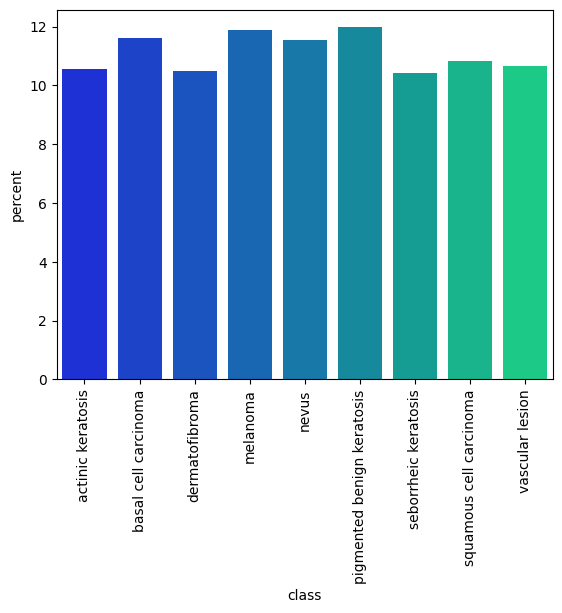

In [33]:

sns.barplot(data=tr_df,x='class',y='percent',palette='winter')
plt.xticks(rotation=90)
plt.show()

So, now we have added 2500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [3]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [4]:
data_dir_train=r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.
Using 4947 files for validation.


## With Dropouts - M1 (32-2x , 64-2x ,128 1x )

In [5]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

In [6]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
619/619 [==============================] - 42s 63ms/step - loss: 1.6891 - accuracy: 0.3317 - val_loss: 1.4247 - val_accuracy: 0.4455
Epoch 2/30
619/619 [==============================] - 37s 60ms/step - loss: 1.4011 - accuracy: 0.4508 - val_loss: 1.3685 - val_accuracy: 0.4550
Epoch 3/30
619/619 [==============================] - 38s 61ms/step - loss: 1.2956 - accuracy: 0.4945 - val_loss: 1.2675 - val_accuracy: 0.5199
Epoch 4/30
619/619 [==============================] - 37s 60ms/step - loss: 1.1948 - accuracy: 0.5361 - val_loss: 1.0886 - val_accuracy: 0.5848
Epoch 5/30
619/619 [==============================] - 39s 62ms/step - loss: 1.1192 - accuracy: 0.5679 - val_loss: 1.0801 - val_accuracy: 0.5868
Epoch 6/30
619/619 [==============================] - 39s 62ms/step - loss: 1.0490 - accuracy: 0.5975 - val_loss: 1.0236 - val_accuracy: 0.6066
Epoch 7/30
619/619 [==============================] - 38s 62ms/step - loss: 0.9932 - accuracy: 0.6183 - val_loss: 0.9686 - val_accuracy:

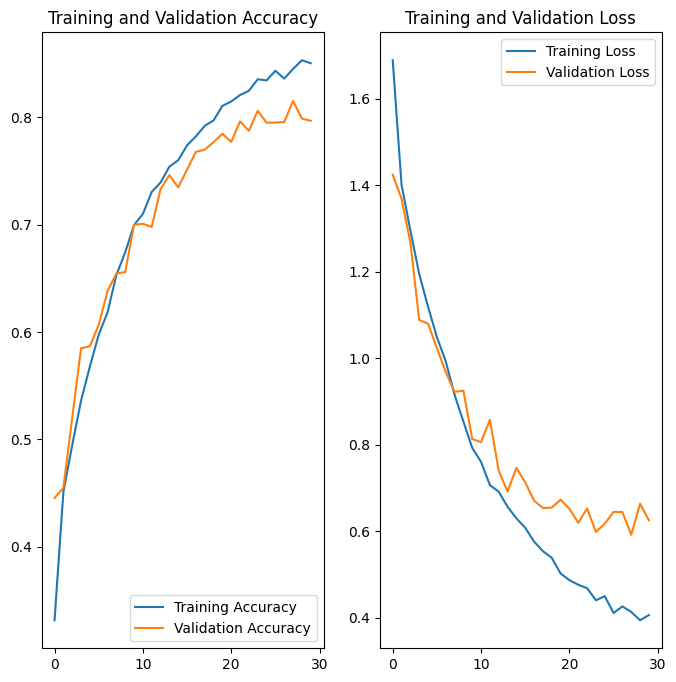

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Dropouts Model - M2 (8 -1x , 16 - 1x , 32- 1x,64 - 1x and 128-1x)




In [8]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 16)        1168      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 32)       

In [9]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 22s 35ms/step - loss: 1.7264 - accuracy: 0.3145 - val_loss: 1.4767 - val_accuracy: 0.4124
Epoch 2/40
619/619 [==============================] - 21s 34ms/step - loss: 1.4388 - accuracy: 0.4341 - val_loss: 1.3586 - val_accuracy: 0.4631
Epoch 3/40
619/619 [==============================] - 21s 34ms/step - loss: 1.3401 - accuracy: 0.4731 - val_loss: 1.2485 - val_accuracy: 0.5124
Epoch 4/40
619/619 [==============================] - 21s 34ms/step - loss: 1.2601 - accuracy: 0.5046 - val_loss: 1.1982 - val_accuracy: 0.5369
Epoch 5/40
619/619 [==============================] - 22s 35ms/step - loss: 1.1470 - accuracy: 0.5546 - val_loss: 1.1038 - val_accuracy: 0.5801
Epoch 6/40
619/619 [==============================] - 21s 34ms/step - loss: 1.0710 - accuracy: 0.5872 - val_loss: 1.0525 - val_accuracy: 0.6036
Epoch 7/40
619/619 [==============================] - 22s 35ms/step - loss: 0.9805 - accuracy: 0.6235 - val_loss: 1.0155 - val_accuracy:

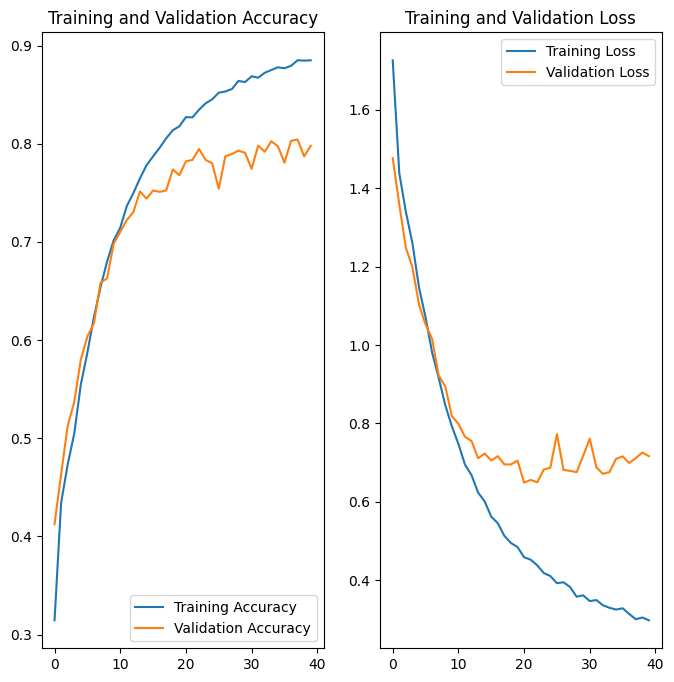

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## With Batch Normalization and Dropouts Model - M3 (8 -1x , 16 - 1x , 32- 1x,64 - 1x and 128-1x)

In [5]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
     layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 16)        1168      
                                                                 
 batch_normalization (BatchN  (None, 87, 87, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 16)       0

In [6]:
epochs = 40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 23s 32ms/step - loss: 1.5190 - accuracy: 0.4331 - val_loss: 1.7556 - val_accuracy: 0.3998
Epoch 2/40
619/619 [==============================] - 21s 34ms/step - loss: 1.1924 - accuracy: 0.5460 - val_loss: 1.1380 - val_accuracy: 0.5775
Epoch 3/40
619/619 [==============================] - 22s 36ms/step - loss: 1.0558 - accuracy: 0.5963 - val_loss: 1.7235 - val_accuracy: 0.3984
Epoch 4/40
619/619 [==============================] - 23s 36ms/step - loss: 0.9600 - accuracy: 0.6357 - val_loss: 1.1501 - val_accuracy: 0.5636
Epoch 5/40
619/619 [==============================] - 23s 38ms/step - loss: 0.8691 - accuracy: 0.6676 - val_loss: 0.9972 - val_accuracy: 0.6339
Epoch 6/40
619/619 [==============================] - 22s 35ms/step - loss: 0.8070 - accuracy: 0.6893 - val_loss: 0.8223 - val_accuracy: 0.6885
Epoch 7/40
619/619 [==============================] - 22s 35ms/step - loss: 0.7430 - accuracy: 0.7167 - val_loss: 1.3079 - val_accuracy:

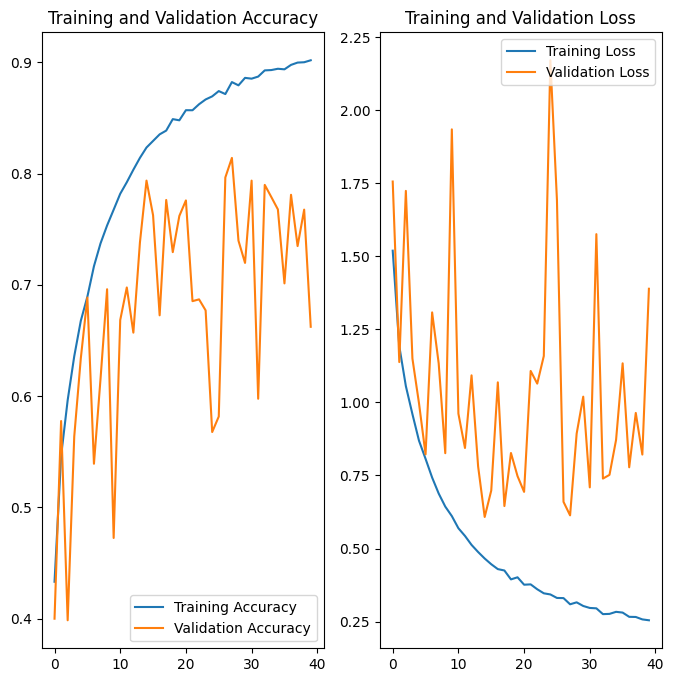

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras import backend as K

# Clear TensorFlow session
K.clear_session()

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

## With Batch Normalization or Dropouts - M4

In [8]:
### Your code goes here
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),


    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 8)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 16)        1168      
                                                                 
 dropout_1 (Dropout)         (None, 87, 87, 16)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 16)       0         
 2D)                                                  

In [9]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
619/619 [==============================] - 24s 38ms/step - loss: 1.6159 - accuracy: 0.3624 - val_loss: 1.4987 - val_accuracy: 0.4269
Epoch 2/50
619/619 [==============================] - 23s 38ms/step - loss: 1.3750 - accuracy: 0.4602 - val_loss: 1.4213 - val_accuracy: 0.4633
Epoch 3/50
619/619 [==============================] - 24s 38ms/step - loss: 1.2570 - accuracy: 0.5079 - val_loss: 1.3312 - val_accuracy: 0.4888
Epoch 4/50
619/619 [==============================] - 22s 36ms/step - loss: 1.1328 - accuracy: 0.5603 - val_loss: 1.2199 - val_accuracy: 0.5383
Epoch 5/50
619/619 [==============================] - 23s 37ms/step - loss: 1.0410 - accuracy: 0.5985 - val_loss: 1.2000 - val_accuracy: 0.5630
Epoch 6/50
619/619 [==============================] - 22s 36ms/step - loss: 0.9173 - accuracy: 0.6498 - val_loss: 1.1274 - val_accuracy: 0.6147
Epoch 7/50
619/619 [==============================] - 23s 36ms/step - loss: 0.8370 - accuracy: 0.6785 - val_loss: 0.9967 - val_accuracy:

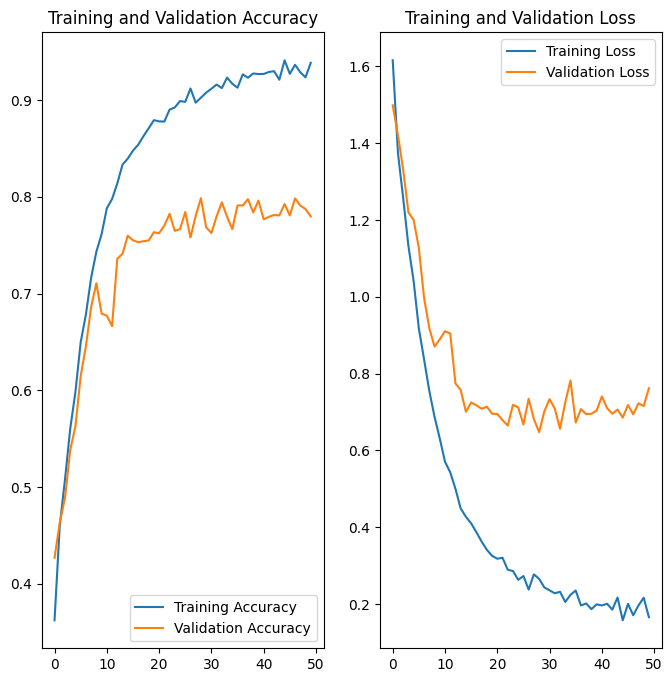

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Observation
 - It can be noted that Model M1 ,M2  and M4 perform the best out of all the models
 - But fluctuations can be seen in M2
 - While M4 has higher accuracy for train data , its test data is almost similar to M1
 - Let's compare between M1 and M4
### Regarding Batch Normalization 
 - It has been observed across all models that batch normalization causes large fluctuations in test data , while also significantly lowering training accuracy below the acceptable threshold
### Obeservations on Class Imbalance Treatment using Augmentation
 - Augmenting the data has provided good results , while not having a dropout layer leads the model to overfit using dropout layers controls this overfit phenomenon and makes the model stable by introducing randomness in the weights
   


# Final Models M1 AND M4

In [4]:
batch_size = 32
img_height = 180
img_width = 180
data_dir_train=r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)

Found 24739 files belonging to 9 classes.
Using 19792 files for training.
Using 4947 files for validation.


## Model M1

In [5]:
### Your code goes here
model_m1 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model_m1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_m1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 64)       

In [6]:
epochs = 30
history= model_m1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
619/619 [==============================] - 36s 53ms/step - loss: 1.6903 - accuracy: 0.3286 - val_loss: 1.5131 - val_accuracy: 0.3990
Epoch 2/30
619/619 [==============================] - 35s 56ms/step - loss: 1.4079 - accuracy: 0.4469 - val_loss: 1.2764 - val_accuracy: 0.5060
Epoch 3/30
619/619 [==============================] - 37s 60ms/step - loss: 1.2892 - accuracy: 0.4928 - val_loss: 1.2674 - val_accuracy: 0.5130
Epoch 4/30
619/619 [==============================] - 36s 59ms/step - loss: 1.1835 - accuracy: 0.5429 - val_loss: 1.1335 - val_accuracy: 0.5626
Epoch 5/30
619/619 [==============================] - 36s 58ms/step - loss: 1.0987 - accuracy: 0.5759 - val_loss: 0.9854 - val_accuracy: 0.6147
Epoch 6/30
619/619 [==============================] - 37s 60ms/step - loss: 0.9999 - accuracy: 0.6127 - val_loss: 0.9135 - val_accuracy: 0.6535
Epoch 7/30
619/619 [==============================] - 38s 62ms/step - loss: 0.9100 - accuracy: 0.6505 - val_loss: 0.8718 - val_accuracy:

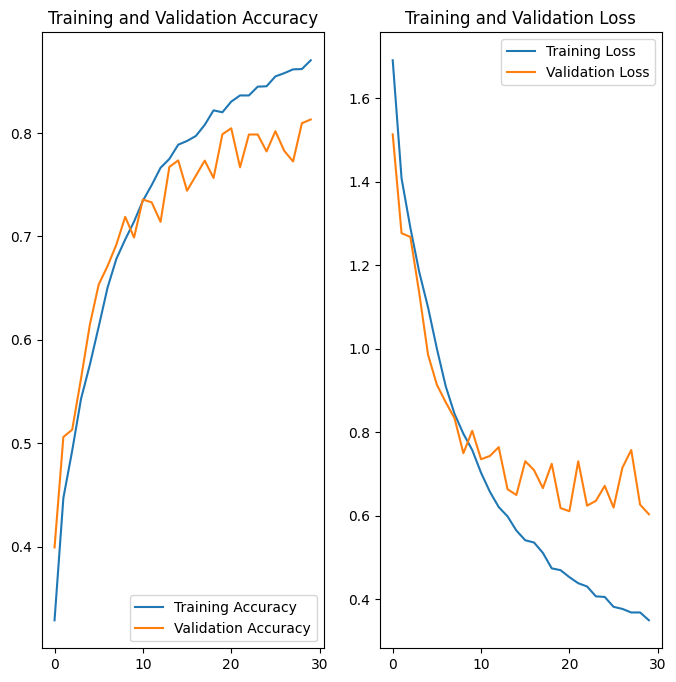

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model M4

In [8]:
### Your code goes here
model_m4 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),


    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.23),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    # layers.BatchNormalization(),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model_m4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_m4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 89, 89, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 16)        1168      
                                                                 
 dropout_2 (Dropout)         (None, 87, 87, 16)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                 

In [9]:
epochs = 50
history = model_m4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
619/619 [==============================] - 23s 35ms/step - loss: 1.6207 - accuracy: 0.3647 - val_loss: 1.4859 - val_accuracy: 0.4439
Epoch 2/50
619/619 [==============================] - 22s 35ms/step - loss: 1.3450 - accuracy: 0.4752 - val_loss: 1.3919 - val_accuracy: 0.4475
Epoch 3/50
619/619 [==============================] - 22s 35ms/step - loss: 1.2169 - accuracy: 0.5313 - val_loss: 1.3357 - val_accuracy: 0.5064
Epoch 4/50
619/619 [==============================] - 22s 35ms/step - loss: 1.0921 - accuracy: 0.5756 - val_loss: 1.1882 - val_accuracy: 0.5476
Epoch 5/50
619/619 [==============================] - 22s 35ms/step - loss: 0.9734 - accuracy: 0.6243 - val_loss: 1.1090 - val_accuracy: 0.6133
Epoch 6/50
619/619 [==============================] - 22s 35ms/step - loss: 0.8778 - accuracy: 0.6639 - val_loss: 1.0702 - val_accuracy: 0.6046
Epoch 7/50
619/619 [==============================] - 22s 35ms/step - loss: 0.7937 - accuracy: 0.6972 - val_loss: 0.9880 - val_accuracy:

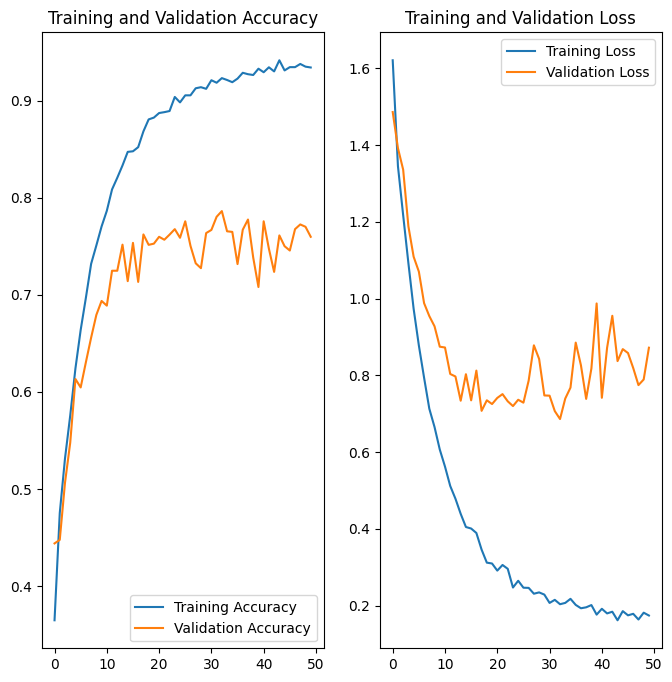

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model_m1.save("m1.h5", include_optimizer=True)
model_m4.save("m4.h5",include_optimizer=True)

# Test Data

In [18]:
data_dir_test = pathlib.Path(r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)


Found 118 files belonging to 9 classes.


# Test Result Model M1

In [19]:
loss , accuracy = model_m1.evaluate(test_ds)
print("Accuracy on test data of Model M1 : ", accuracy)
print("Loss on test data of Model M1", loss)


4/4 [==============================] - 1s 15ms/step - loss: 4.5260 - accuracy: 0.4068
Accuracy on test data of Model M1 :  0.4067796468734741
Loss on test data of Model M1 4.526043891906738


# Test Result Model M4

In [25]:
loss , accuracy = model_m4.evaluate(test_ds)
print("Accuracy on test data of Model M4 : ", accuracy)
print("Loss on test data of Model M4", loss)


4/4 [==============================] - 1s 11ms/step - loss: 4.4269 - accuracy: 0.4661
Accuracy on test data of Model M4 :  0.4661017060279846
Loss on test data of Model M4 4.426915168762207


# Additional Models

### Additionally Let's try model M2 
 - Since Models M1 and M4 turned out as they did let's try model M2 just in case

In [21]:
### Your code goes here
model_m2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Conv2D(8, (3, 3), activation='relu'),
    # layers.Dropout(0.25),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(16, (3, 3), activation='relu'),
    # layers.Dropout(0.4),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model_m2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_m2.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 8)       224       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 89, 89, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 16)        1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 43, 43, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 41, 41, 32)       

In [22]:
epochs = 40
history = model_m2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 18s 29ms/step - loss: 1.6928 - accuracy: 0.3298 - val_loss: 1.4422 - val_accuracy: 0.4330
Epoch 2/40
619/619 [==============================] - 18s 29ms/step - loss: 1.3925 - accuracy: 0.4507 - val_loss: 1.2650 - val_accuracy: 0.5205
Epoch 3/40
619/619 [==============================] - 19s 31ms/step - loss: 1.2384 - accuracy: 0.5214 - val_loss: 1.1284 - val_accuracy: 0.5678
Epoch 4/40
619/619 [==============================] - 20s 31ms/step - loss: 1.1265 - accuracy: 0.5664 - val_loss: 1.0768 - val_accuracy: 0.5852
Epoch 5/40
619/619 [==============================] - 20s 31ms/step - loss: 1.0385 - accuracy: 0.6023 - val_loss: 1.0162 - val_accuracy: 0.6182
Epoch 6/40
619/619 [==============================] - 21s 34ms/step - loss: 0.9456 - accuracy: 0.6378 - val_loss: 0.9487 - val_accuracy: 0.6398
Epoch 7/40
619/619 [==============================] - 21s 34ms/step - loss: 0.8677 - accuracy: 0.6679 - val_loss: 0.9229 - val_accuracy:

In [23]:
model_m2.save("m2.h5",include_optimizer=True)

# Model 2 Performs Similar to M1

In [24]:
loss , accuracy = model_m2.evaluate(test_ds)
print("Accuracy on test data of Model M2 : ", accuracy)
print("Loss on test data of Model M2", loss)


4/4 [==============================] - 1s 12ms/step - loss: 5.2239 - accuracy: 0.4068
Accuracy on test data of Model M1 :  0.4067796468734741
Loss on test data of Model M1 5.223940372467041


# Add more Dropouts to Model M1 call it M5

In [4]:
### Your code goes here
batch_size = 32
img_height = 180
img_width = 180
data_dir_train=r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='both',)
model_m5 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.24),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.24),
    #  layers.BatchNormalization(),
    # layers.Dropout(0.2),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.24),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.24),
    #  layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9, activation='softmax')
])
### Todo, choose an appropirate optimiser and loss function
model_m5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_m5.summary()


Found 24739 files belonging to 9 classes.
Using 19792 files for training.
Using 4947 files for validation.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 dropout (Dropout)           (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 dropout_1 (Dro

In [5]:
epochs = 40
history = model_m5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
619/619 [==============================] - 46s 68ms/step - loss: 1.6915 - accuracy: 0.3355 - val_loss: 1.7031 - val_accuracy: 0.3548
Epoch 2/40
619/619 [==============================] - 44s 71ms/step - loss: 1.3869 - accuracy: 0.4613 - val_loss: 1.5488 - val_accuracy: 0.3736
Epoch 3/40
619/619 [==============================] - 45s 72ms/step - loss: 1.2426 - accuracy: 0.5218 - val_loss: 1.4853 - val_accuracy: 0.3994
Epoch 4/40
619/619 [==============================] - 47s 76ms/step - loss: 1.1261 - accuracy: 0.5682 - val_loss: 1.4906 - val_accuracy: 0.4043
Epoch 5/40
619/619 [==============================] - 46s 74ms/step - loss: 1.0280 - accuracy: 0.6062 - val_loss: 1.2863 - val_accuracy: 0.5005
Epoch 6/40
619/619 [==============================] - 46s 75ms/step - loss: 0.9444 - accuracy: 0.6443 - val_loss: 1.2259 - val_accuracy: 0.5470
Epoch 7/40
619/619 [==============================] - 46s 74ms/step - loss: 0.8353 - accuracy: 0.6850 - val_loss: 1.1962 - val_accuracy:

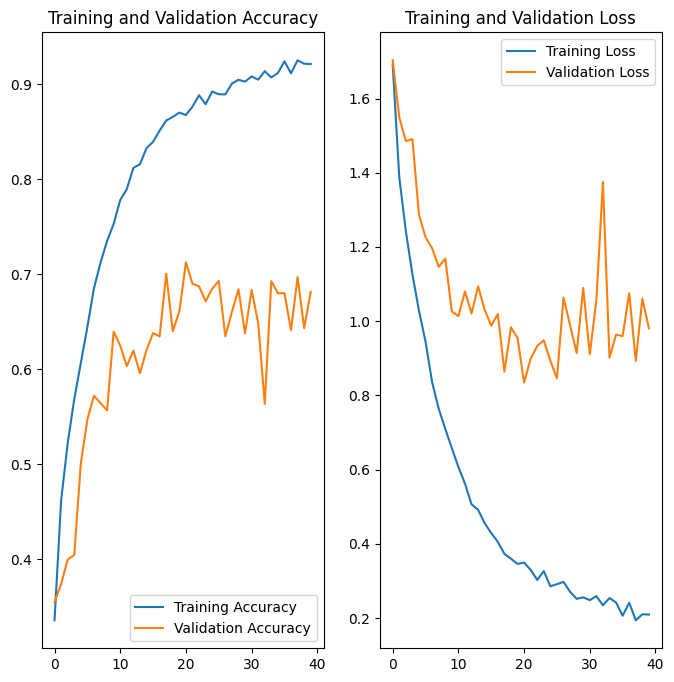

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [7]:
model_m5.save("m5.h5",include_optimizer=True)

In [9]:
data_dir_test = pathlib.Path(r"C:\Users\srini\Melanoma-Detection-Assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

loss , accuracy = model_m5.evaluate(test_ds)
print("Accuracy on test data of Model M5 : ", accuracy)
print("Loss on test data of Model M5", loss)


Found 118 files belonging to 9 classes.
4/4 [==============================] - 1s 90ms/step - loss: 3.7996 - accuracy: 0.4322
Accuracy on test data of Model M5 :  0.43220338225364685
Loss on test data of Model M5 3.7995543479919434
